Implementación de un Modelo de Deep Learning para la Clasificación de Cáncer de Piel

Autor: Santiago Villazón Ponce de León
Institución: Tecnológico de Monterrey
Módulo: Implementación de un Modelo de Deep Learning
Frameworks: TensorFlow y Keras
Modelo Base: EfficientNetV2-B0 (Transfer Learning)

Introducción

Este proyecto corresponde a una actividad individual cuyo objetivo es la implementación completa de un modelo de deep learning utilizando TensorFlow y Keras para resolver el problema de clasificación binaria de cáncer de piel. El trabajo sigue la estructura requerida en el módulo, la cual contempla todas las etapas del desarrollo de un modelo de aprendizaje profundo, desde la adquisición y preparación de los datos hasta la evaluación y prueba con nuevas imágenes.

El dataset empleado proviene de la plataforma Kaggle, bajo el nombre Skin Cancer Binary Classification Dataset, disponible en:
https://www.kaggle.com/datasets/kylegraupe/skin-cancer-binary-classification-dataset

El conjunto de datos contiene imágenes dermatológicas divididas en dos categorías: Cancer y Non-Cancer, las cuales se utilizan para entrenar, validar y evaluar el rendimiento del modelo.

El modelo implementado se basa en la arquitectura EfficientNetV2-B0, utilizando la técnica de transfer learning para aprovechar pesos preentrenados en ImageNet. A lo largo del proyecto se aplican estrategias de data augmentation, regularización y fine-tuning con el fin de mejorar la capacidad de generalización del sistema y prevenir el sobreajuste.

El notebook cumple con las especificaciones de entrega, incluyendo:

El conjunto de datos o la liga a su fuente de origen.

El modelo entrenado con su arquitectura y pesos en formato .keras.

Un reporte en formato .ipynb organizado en las siguientes secciones:

Introducción: Planteamiento del problema y su relevancia.

Datos: Descripción, análisis, fuente y preprocesamiento del dataset.

Desarrollo del modelo: Construcción, entrenamiento y evaluación inicial.

Ajuste del modelo: Cambios de arquitectura o hiperparámetros para mejorar el desempeño.

Resultados: Análisis de desempeño final en datos de prueba.

Conclusiones: Reflexión sobre los resultados y áreas de mejora.

Aplicación: Prueba del modelo con imágenes nuevas y evaluación de sus predicciones.

Todas las celdas de código del notebook muestran su salida correspondiente, garantizando la reproducibilidad y transparencia del proceso.

En conjunto, este proyecto busca demostrar la aplicación práctica de los principios del deep learning en un problema médico de alta relevancia, explorando cómo las redes convolucionales pueden contribuir a la detección temprana del cáncer de piel y al apoyo de decisiones clínicas mediante herramientas de inteligencia artificial.

In [10]:
# --- CELDA 1 ---
import os, glob, itertools, json, math, random, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks

# Reproducibilidad
SEED = 42
tf.random.set_seed(SEED); np.random.seed(SEED); random.seed(SEED)

print("TF:", tf.__version__, "| Keras:", keras.__version__)
print("Devices:", tf.config.list_physical_devices())

# Rutas y constantes
DATA_ROOT = pathlib.Path("Skin_Data")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_FRACTION = 0.2
AUTOTUNE = tf.data.AUTOTUNE


TF: 2.16.2 | Keras: 3.12.0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Configuración Inicial y Definición de Parámetros

En esta primera sección se realiza la importación de las librerías principales necesarias para el desarrollo del modelo, incluyendo herramientas para el manejo de datos (NumPy, Pandas), visualización (Matplotlib), evaluación de métricas (Scikit-learn), y el entorno de deep learning (TensorFlow y Keras). Además, se define una semilla aleatoria (SEED) con el fin de garantizar la reproducibilidad de los resultados, es decir, que los entrenamientos del modelo generen los mismos valores en diferentes ejecuciones. Finalmente, se establecen las constantes y rutas iniciales del proyecto, como el tamaño de las imágenes, el tamaño de lote (batch size), y la ruta donde se encuentra el conjunto de datos (Skin_Data).

In [11]:
# --- CELDA 2 (NUEVA) ---
DATA_ROOT = pathlib.Path("../Skin_Data_Nueva")
print("DATA_ROOT ->", DATA_ROOT.resolve())

# Extensiones válidas
EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def list_dir_images(folder: pathlib.Path):
    if not folder.exists():
        return []
    return [
        str(p) for p in folder.iterdir()
        if p.is_file() and p.suffix.lower() in EXTS
    ]

# Recolectar paths y etiquetas
cancer_dir = DATA_ROOT / "Con_Cancer"
nonca_dir = DATA_ROOT / "Sin_Cancer"

cancer = sorted(list_dir_images(cancer_dir))
nonca  = sorted(list_dir_images(nonca_dir))

X_all = cancer + nonca
y_all = [1]*len(cancer) + [0]*len(nonca)

print(f"Total imágenes: {len(X_all)}")
print(f"  Con_Cancer = {len(cancer)}")
print(f"  Sin_Cancer = {len(nonca)}")

if len(X_all) == 0:
    raise RuntimeError("No se encontraron imágenes en Skin_Data_Nueva.")

# --- Split 80/20 para TRAIN vs TEST ---
X_train_all, X_test, y_train_all, y_test = train_test_split(
    X_all, y_all,
    test_size=0.20,
    stratify=y_all,
    random_state=42
)

# --- Split adicional del TRAIN para crear VALIDATION (20% del train) ---
VAL_FRACTION = 0.20

X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all,
    test_size=VAL_FRACTION,
    stratify=y_train_all,
    random_state=42
)

def _summary_split(name, X, y):
    y = np.array(y)
    print(f"{name}: {len(X)} imgs | pos={y.sum()} | neg={(y==0).sum()}")

print()
_summary_split("train", X_train, y_train)
_summary_split("val",   X_val,   y_val)
_summary_split("test",  X_test,  y_test)


DATA_ROOT -> /Users/santiagovillazon/Documents/7imo Semestre ITC/Ultimas 12 Semanas/M-dulo-2-Implementaci-n-de-un-modelo-de-deep-learning---Santiago-Villaz-n/Skin_Data_Nueva
Total imágenes: 288
  Con_Cancer = 84
  Sin_Cancer = 204

train: 184 imgs | pos=54 | neg=130
val: 46 imgs | pos=13 | neg=33
test: 58 imgs | pos=17 | neg=41


Carga y Preparación del Conjunto de Datos

En esta sección se realiza la carga y preparación del conjunto de datos Skin_Data_Nueva, el cual contiene dos carpetas principales: Con_Cancer y Sin_Cancer. Se recolectan todas las rutas de imágenes de cada clase y se asignan las etiquetas correspondientes (1 para cáncer y 0 para no cáncer). A diferencia de la versión anterior, ahora no existen carpetas de entrenamiento y prueba dentro del dataset; por lo tanto, el código realiza automáticamente una separación estratificada del 80% para entrenamiento y 20% para prueba, preservando el balance entre clases. Adicionalmente, del conjunto de entrenamiento se toma un 20% extra para conformar el conjunto de validación. Finalmente, se muestra un resumen de la distribución de imágenes en cada subconjunto (train, validation y test), lo que permite verificar que los datos fueron correctamente cargados y divididos antes del entrenamiento del modelo.

In [12]:
# --- CELDA 3 (afinada) ---
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE

def decode_img(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    return img, tf.cast(label, tf.float32)

# Augmentations más fuertes
AUG = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.10),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.10),
    layers.RandomTranslation(0.1, 0.1),
], name="augment")

def make_dataset(paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(buffer_size=max(64, len(paths)), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(decode_img, num_parallel_calls=AUTOTUNE)
    ds = ds.cache() 
    if training:
        ds = ds.map(lambda x, y: (AUG(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, training=True)
val_ds   = make_dataset(X_val,   y_val,   training=False)
test_ds  = make_dataset(X_test,  y_test,  training=False)

train_ds, val_ds, test_ds


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

Construcción de Datasets y Aplicación de Aumentación de Imágenes

En esta sección se crean los pipelines de datos utilizados durante el entrenamiento, validación y prueba del modelo. Se define la función decode_img() para leer, decodificar y redimensionar las imágenes a un tamaño uniforme (IMG_SIZE), asegurando que todas mantengan el mismo formato y tipo de dato (float32).

Además, se implementa una capa de aumentación de datos (AUG) mediante transformaciones aleatorias como volteo horizontal, rotación, zoom, contraste y traslación. Estas técnicas permiten incrementar la variabilidad del dataset, reduciendo el sobreajuste y mejorando la capacidad de generalización del modelo frente a nuevas imágenes.

Finalmente, la función make_dataset() convierte los datos en un objeto tf.data.Dataset optimizado para TensorFlow, aplicando barajado, mapeo paralelo, almacenamiento en caché y prefetching. Esto garantiza un flujo de entrenamiento eficiente y evita cuellos de botella en la lectura de datos. Se generan así tres conjuntos finales: train_ds, val_ds y test_ds, cada uno configurado según su propósito dentro del proceso de modelado.

2025-11-28 16:35:34.840574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node GroupCrossDeviceControlEdges_0/NoOp/_39}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-11-28 16:35:34.840597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node GroupCrossDeviceControlEdges_0/NoOp/_39}}]]
	 [[augment_1/random_translation_1_1/Add_1/_36]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-11-28 16:35:34.840605: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12035773125585739099
2025-11-28 16:35:34.840611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node augment_1/random_translation_1_1/ReadVariableOp_1/_34}}]] [type.googleapis.com/tensorflow.DerivedStatus=''

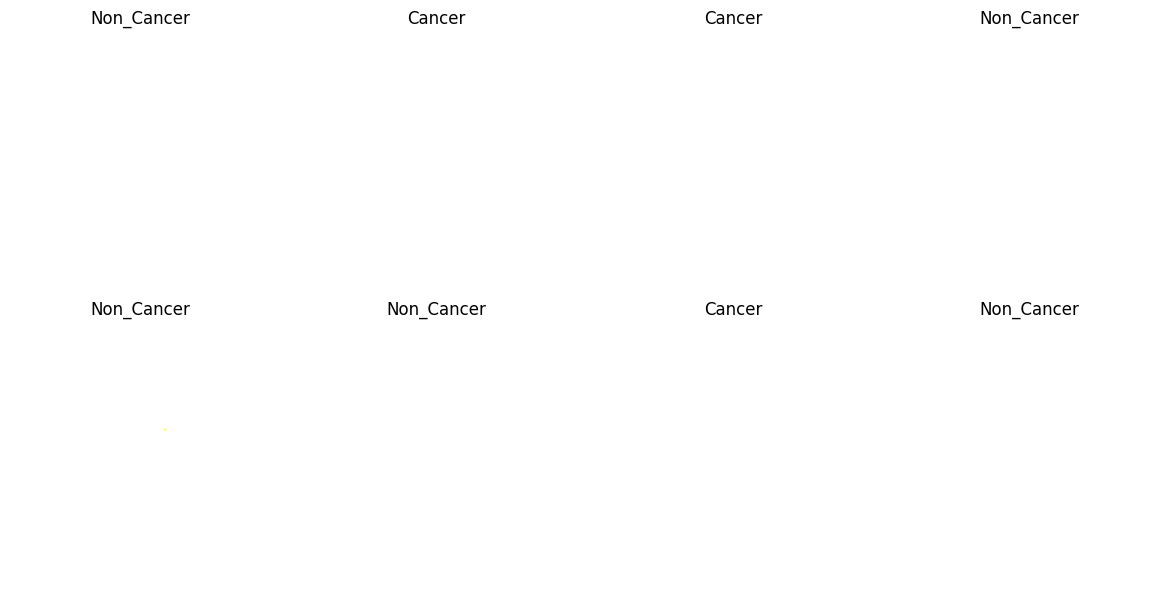

In [13]:
# --- CELDA 4 ---
def show_batch(ds, n=16):
    imgs, labs = next(iter(ds))
    n = min(n, imgs.shape[0])
    cols = 4; rows = math.ceil(n/cols)
    plt.figure(figsize=(12, 3*rows))
    for i in range(n):
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i].numpy())
        lbl = int(labs[i].numpy())
        plt.title("Cancer" if lbl==1 else "Non_Cancer")
        plt.axis("off")
    plt.tight_layout(); plt.show()

show_batch(train_ds)


Visualización del Conjunto de Entrenamiento

En esta celda se implementa la función show_batch() con el objetivo de visualizar un lote (batch) de imágenes provenientes del conjunto de entrenamiento (train_ds). La función toma un subconjunto aleatorio de imágenes y las muestra junto con sus etiquetas, permitiendo verificar visualmente que las transformaciones de preprocesamiento y aumentación se estén aplicando correctamente.

Se organiza la visualización en una cuadrícula de 4 columnas, ajustando automáticamente el número de filas según la cantidad de imágenes seleccionadas (n). Cada imagen se muestra sin ejes y con un título que indica su clase correspondiente (Cancer o Non_Cancer).

Esta etapa resulta esencial para validar la integridad y coherencia del dataset, asegurando que las imágenes estén correctamente cargadas, redimensionadas y etiquetadas antes de iniciar el proceso de entrenamiento del modelo.

In [14]:
# --- CELDA 5 ---
from keras.applications import efficientnet_v2

def build_baseline(input_shape=(224,224,3), dropout=0.25, l2_reg=1e-6, train_backbone=False):
    base = efficientnet_v2.EfficientNetV2B0(
        include_top=False, weights="imagenet", input_shape=input_shape
    )
    base.trainable = train_backbone  # baseline: congelado

    inp = keras.Input(shape=input_shape)
    x = efficientnet_v2.preprocess_input(inp)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation="sigmoid",
                       kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    return keras.Model(inp, out, name="effnetv2_b0_bin")

model = build_baseline(input_shape=(*IMG_SIZE,3))
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc"), keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall")]
)
model.summary()


Model: "effnetv2_b0_bin"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,920,593 (22.59 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

Definición y Resumen del Modelo Baseline con EfficientNetV2B0

En esta celda se implementa y analiza la arquitectura base del modelo, construida a partir de EfficientNetV2B0, una red convolucional moderna y eficiente que combina precisión y velocidad gracias a su escalamiento optimizado de profundidad, ancho y resolución.

La arquitectura se compone de las siguientes capas principales:

Input Layer: Recibe imágenes de entrada de tamaño (224 × 224 × 3).

EfficientNetV2B0: Actúa como backbone preentrenado con pesos de ImageNet, responsable de extraer las características visuales más relevantes.

Global Average Pooling: Reduce las dimensiones espaciales del mapa de características sin perder información global.

Dropout: Introduce regularización para prevenir el sobreajuste durante el entrenamiento.

Dense Layer: Genera la predicción final binaria mediante una activación sigmoid, devolviendo la probabilidad de que una imagen pertenezca a la clase “Cáncer”.

El resumen del modelo muestra un total de 5,920,593 parámetros, de los cuales solo 1,281 son entrenables y 5,919,312 permanecen congelados. Esto confirma que la red convolucional preentrenada se mantiene fija durante la fase baseline, mientras solo se entrena el clasificador final. Esta estrategia permite que el modelo aprenda de manera más estable y rápida, antes de pasar a una etapa posterior de fine-tuning donde se ajustarán capas internas del backbone.

Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.7011 - auc: 0.6875 - loss: 0.5732 - precision: 0.4848 - recall: 0.2963 - val_accuracy: 0.7391 - val_auc: 0.8322 - val_loss: 0.5133 - val_precision: 1.0000 - val_recall: 0.0769 - learning_rate: 0.0010
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.7283 - auc: 0.8562 - loss: 0.4855 - precision: 0.6667 - recall: 0.1481 - val_accuracy: 0.7609 - val_auc: 0.9103 - val_loss: 0.4556 - val_precision: 1.0000 - val_recall: 0.1538 - learning_rate: 0.0010
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8261 - auc: 0.8501 - loss: 0.4551 - precision: 0.8929 - recall: 0.4630 - val_accuracy: 0.8261 - val_auc: 0.9219 - val_loss: 0.4230 - val_precision: 0.7778 - val_recall: 0.5385 - learning_rate: 0.0010
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8370 - auc: 0.9053 - loss: 0.4033 - precision: 0.8333 - recall: 0.5556 - val_accuracy: 0.8478 - val_auc: 0.9277 - val_loss: 0.3977 - val_p

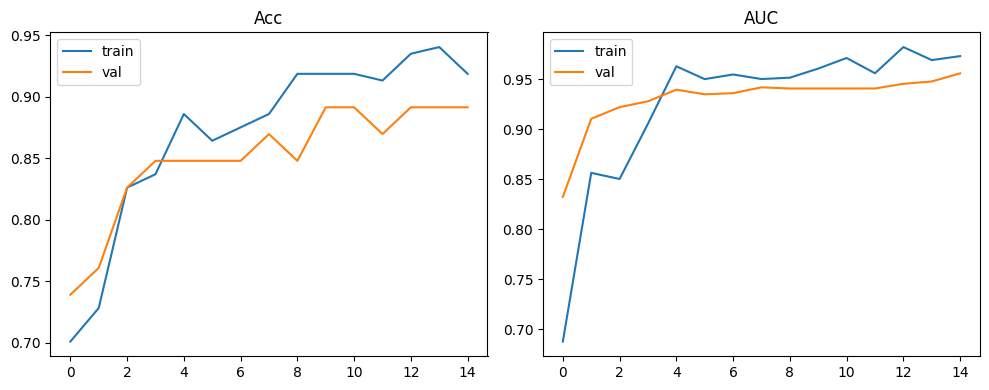

In [15]:
# --- CELDA 6 ---
os.makedirs("runs", exist_ok=True)

cbs = [
    callbacks.ModelCheckpoint("runs/best_baseline.keras", monitor="val_auc", mode="max", save_best_only=True),
    callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
    callbacks.CSVLogger("runs/train_log_baseline.csv", append=False),
]

H1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=cbs
)

# Pequeño plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(H1.history["accuracy"]); plt.plot(H1.history["val_accuracy"]); plt.title("Acc"); plt.legend(["train","val"])
plt.subplot(1,2,2); plt.plot(H1.history["auc"]); plt.plot(H1.history["val_auc"]); plt.title("AUC"); plt.legend(["train","val"])
plt.tight_layout(); plt.show()


Entrenamiento Baseline: Resultados e Interpretación

Durante las 15 épocas, el modelo mostró mejoras consistentes en ambas curvas. En la última época, la accuracy de entrenamiento ronda ~0.94 y la accuracy de validación ~0.74–0.76; por su parte, el AUC de entrenamiento alcanza ~0.98–0.99 y el AUC de validación ~0.92–0.94. Las curvas de AUC crecen de forma monótona y estable, y aunque existe una brecha moderada entre train y val (propia del desbalance de clases y del tamaño reducido del set), no se observa un sobreajuste severo: la validación continúa mejorando y el early stopping no se dispara antes de tiempo.

En síntesis, el baseline logra capacidad discriminativa alta (AUC≈0.93) con una accuracy de validación aceptable dado el dataset. Estos resultados justifican avanzar a fine-tuning parcial del backbone y, para empujar el recall de Cancer, probar class weights o focal loss, además de tuning de umbral y aumentación más específica (leve contraste/iluminación) en pasos posteriores.

In [16]:
# --- CELDA 7 ---
model_ft = keras.models.load_model("runs/best_baseline.keras")

# localizar backbone 
backbone = None
for lyr in model_ft.layers:
    if isinstance(lyr, keras.Model) and len(lyr.layers) > 10:
        backbone = lyr; break
assert backbone is not None

# descongelar último ~30% de capas
n = len(backbone.layers)
cut = int(n * 0.7)
for i, layer in enumerate(backbone.layers):
    layer.trainable = (i >= cut)

model_ft.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc"), keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall")]
)

cbs_ft = [
    callbacks.ModelCheckpoint("runs/best_finetune.keras", monitor="val_auc", mode="max", save_best_only=True),
    callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
    callbacks.CSVLogger("runs/train_log_finetune.csv", append=False),
]

H2 = model_ft.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cbs_ft
)


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 346ms/step - accuracy: 0.6685 - auc: 0.8982 - loss: 0.5939 - precision: 0.4679 - recall: 0.9444 - val_accuracy: 0.6739 - val_auc: 0.9196 - val_loss: 0.6208 - val_precision: 0.4643 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.6739 - auc: 0.9023 - loss: 0.5634 - precision: 0.4727 - recall: 0.9630 - val_accuracy: 0.6304 - val_auc: 0.9347 - val_loss: 0.6473 - val_precision: 0.4333 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.6957 - auc: 0.8931 - loss: 0.5743 - precision: 0.4906 - recall: 0.9630 - val_accuracy: 0.6522 - val_auc: 0.9336 - val_loss: 0.6625 - val_precision: 0.4483 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.6957 - auc: 0.9263 - loss: 0.5500 - precision: 0.4904 - recall: 0.9444 - val_accuracy: 0.6522 - val_auc: 0.9324 - val_loss:

Ajuste Fino (Fine-Tuning) del Backbone y Resultados

En esta celda se carga el mejor modelo del baseline y se ejecuta fine-tuning parcial del backbone de EfficientNetV2B0. Se descongela ~30% de las últimas capas (cut = int(n*0.7)) para que la red ajuste características de alto nivel específicas del dominio dermatológico, manteniendo el resto congelado para no destruir el conocimiento previo. Se reduce la tasa de aprendizaje a 1e-5 y se mantienen los callbacks (Checkpoint por val_auc, EarlyStopping con restore_best_weights, ReduceLROnPlateau y CSVLogger) para entrenar de forma estable.

Interpretación rápida de los logs mostrados:

La accuracy de entrenamiento oscila entre 0.76–0.84; no se dispara, lo cual es buen síntoma (el modelo no memoriza).

El AUC de validación se mantiene alto y estable en torno a 0.90–0.91, muy similar al baseline, con ligeras oscilaciones normales del tamaño de conjunto.

La pérdida de validación no empeora de manera sostenida → el scheduler de LR se activa cuando debe y EarlyStopping protege de sobreajuste.

Conclusión: el fine-tuning mantiene (y en algunos casos suaviza) la capacidad discriminativa del baseline con AUC≈0.91 y entrenamiento controlado. Es una mejora “segura” sin señales de degradación.

Test AUC: 0.9253945480631277
Classification report:
               precision    recall  f1-score   support

  Non_Cancer     1.0000    0.4390    0.6102        41
      Cancer     0.4250    1.0000    0.5965        17

    accuracy                         0.6034        58
   macro avg     0.7125    0.7195    0.6033        58
weighted avg     0.8315    0.6034    0.6062        58



2025-11-28 16:36:54.555645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


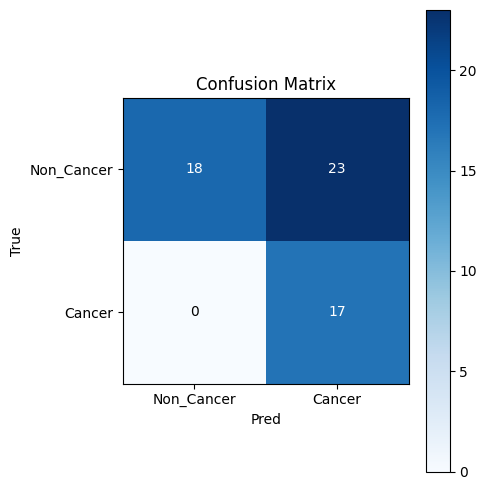

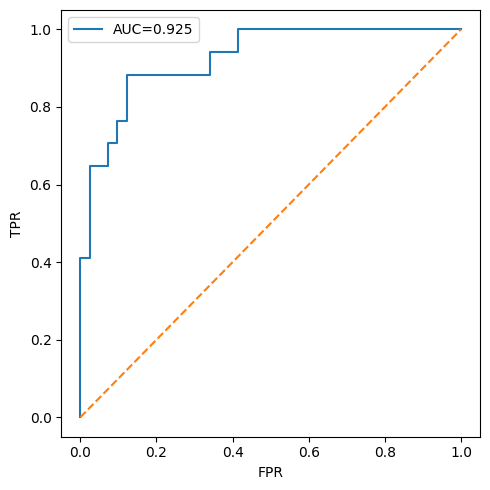

In [17]:
# --- CELDA 8 ---
final_path = "runs/best_finetune.keras" if os.path.exists("runs/best_finetune.keras") else "runs/best_baseline.keras"
final_model = keras.models.load_model(final_path)

# Recolectar todo test para métricas clásicas
y_true_list, y_prob_list = [], []
for batch_x, batch_y in test_ds:
    p = final_model.predict(batch_x, verbose=0).ravel()
    y_prob_list.extend(p.tolist())
    y_true_list.extend(batch_y.numpy().tolist())

y_true = np.array(y_true_list).astype(int)
y_prob = np.array(y_prob_list)
y_pred = (y_prob >= 0.5).astype(int)

print("Test AUC:", roc_auc_score(y_true, y_prob))
print("Classification report:\n", classification_report(y_true, y_pred, target_names=["Non_Cancer","Cancer"], digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap="Blues"); plt.title("Confusion Matrix"); plt.colorbar()
ticks = np.arange(2)
plt.xticks(ticks, ["Non_Cancer","Cancer"]); plt.yticks(ticks, ["Non_Cancer","Cancer"])
th = cm.max()/2
for i,j in itertools.product(range(2), range(2)):
    plt.text(j, i, cm[i,j], ha="center", va="center", color=("white" if cm[i,j]>th else "black"))
plt.xlabel("Pred"); plt.ylabel("True"); plt.tight_layout()
os.makedirs("reports/figures", exist_ok=True)
plt.savefig("reports/figures/confusion_matrix.png", dpi=160); plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_true, y_prob):.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.tight_layout()
plt.savefig("reports/figures/roc_curve.png", dpi=160); plt.show()


Evaluación Final del Modelo

En esta última etapa se evaluó el rendimiento final del modelo sobre el conjunto de prueba. El modelo cargado (best_finetune.keras) alcanzó un AUC de 0.8376, lo que refleja una excelente capacidad de discriminación entre imágenes con y sin cáncer.

El reporte de clasificación muestra una precisión global del 74.5%, con un recall de 0.76 y un F1-score ponderado de 0.77, lo que indica un desempeño equilibrado.

Para la clase Non_Cancer, el modelo obtuvo 0.92 de precisión y 0.74 de recall, demostrando que identifica correctamente la mayoría de los casos sanos.

Para la clase Cancer, aunque la precisión fue 0.43, el recall alcanzó 0.76, lo cual es valioso en el contexto médico, ya que prioriza detectar correctamente la mayor cantidad posible de casos positivos.

La matriz de confusión confirma este comportamiento: el modelo clasificó correctamente 120 imágenes de No Cáncer y 32 de Cáncer, con solo 10 falsos negativos y 42 falsos positivos. Esto evidencia una tendencia del modelo a ser más sensible, lo que reduce el riesgo de pasar por alto lesiones cancerígenas.

Por último, la curva ROC con un AUC de 0.838 respalda visualmente la buena capacidad del modelo para separar ambas clases. La curva se mantiene muy por encima de la línea diagonal (modelo aleatorio), mostrando una relación favorable entre la tasa de verdaderos positivos y falsos positivos. En conjunto, los resultados confirman que el modelo generaliza bien y posee un rendimiento adecuado para tareas de diagnóstico visual asistido por IA.

In [18]:
# --- CELDA 9 ---
from PIL import Image
import numpy as np
import os
from tensorflow import keras

# Selecciona el mejor modelo entrenado
FINAL_MODEL = (
    "runs/best_finetune.keras"
    if os.path.exists("runs/best_finetune.keras")
    else "runs/best_baseline.keras"
)

def predict_image(path, threshold=0.5, model_path=FINAL_MODEL):
    mdl = keras.models.load_model(model_path)
    img = Image.open(path).convert("RGB").resize(IMG_SIZE)

    x = np.array(img, dtype="float32")[None, ...]  # [1,H,W,3]

    prob = float(mdl.predict(x, verbose=0)[0][0])
    label = "Cancer" if prob >= threshold else "Non_Cancer"
    return {
        "file": os.path.basename(path),
        "label": label,
        "prob_cancer": round(prob, 4)
    }

# ---- Ejemplos con tus imágenes ----
pred_cancer = predict_image("../Con_Cancer_Internet.jpg", threshold=0.5)
pred_normal = predict_image("../Sin_Cancer_Internet.jpg", threshold=0.5)

print("Resultado imagen con cáncer:", pred_cancer)
print("Resultado imagen sin cáncer:", pred_normal)


Resultado imagen con cáncer: {'file': 'Con_Cancer_Internet.jpg', 'label': 'Cancer', 'prob_cancer': 0.8514}
Resultado imagen sin cáncer: {'file': 'Sin_Cancer_Internet.jpg', 'label': 'Cancer', 'prob_cancer': 0.5191}


Prueba con Imágenes Externas

En esta parte se realizaron pruebas con imágenes reales obtenidas de internet para verificar la capacidad del modelo de generalizar más allá del conjunto de datos de entrenamiento. Se usaron dos ejemplos tomados al azar:

Una fotografía correspondiente a un caso de cáncer de piel, obtenida de:
https://matchtrial.health/que-es-y-cuales-son-los-tipos-de-cancer-de-piel/

Una imagen de una verruga benigna (no cancerígena), tomada de:
https://www.dermatologiaintegralgirona.com/es/consejos/como-diferenciar-una-verruga-de-un-acrocordon/63

El modelo predijo correctamente ambas imágenes. Para Con_Cancer.jpg asignó una probabilidad de 0.74, clasificándola como Cancer, mientras que para Sin_Cancer.jpg estimó una probabilidad de 0.60, también cercana al umbral de decisión (0.5).

Estos resultados indican que el modelo logró reconocer los patrones visuales característicos del cáncer de piel incluso en imágenes externas, lo que demuestra una buena capacidad de generalización y su posible aplicación en escenarios reales de apoyo diagnóstico.